In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re

import grakel as gk


sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
#from importlib import reload
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['mmdutils'])
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
import MMDforGraphs as mg
importlib.reload(sys.modules['MMDforGraphs'])
import myKernels.WWL as wl

In [40]:
np.int32(np.array([3/7, 2/7, 2/7])*60)

array([25, 17, 17])

In [2]:
ok = pd.read_pickle('../data/test.pkl')

In [52]:

noise = 0.02
block_label_probability = 1.0 - noise
noise = noise/2.0

n1 = 60
n2 = 60

# np.array([[0.15, 0.05, 0.02], [0.05, 0.25, 0.07], [0.02, 0.07, 0.2]])
# np.array([[0.15, 0.05, 0.05], [0.05, 0.15, 0.05], [0.05, 0.05, 0.15]])

probs_1 = np.array([[0.15, 0.05, 0.02], [0.05, 0.25, 0.07], [0.02, 0.07, 0.2]])
label_pmf_1 = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
sizes_1 = [30, 20, 25]
bg1 = mg.SBMGraphs(n = n1, sizes = sizes_1, P = probs_1, l = 'BlockLabelling', params= {'label_pmf':label_pmf_1}, fullyConnected=True)

probs_2 = np.array([[0.15, 0.05, 0.02], [0.05, 0.25, 0.07], [0.02, 0.07, 0.2]])
label_pmf_2 = np.array([[block_label_probability, noise, noise], [noise, block_label_probability, noise], [noise, noise, block_label_probability]])
sizes_2 = [30, 20, 25]
bg2 = mg.SBMGraphs(n = n2, sizes = sizes_2, P = probs_2, l = 'BlockLabelling', params= {'label_pmf':label_pmf_2}, fullyConnected=True)




In [66]:
bg1.Generate()

bg2.Generate()

Gs = bg1.Gs + bg2.Gs

# kernel = [{"name": "multiscale_laplacian"}]
# K = mg.KernelMatrix(graph_list, kernel, False)
graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')    
#kernel = [{"name": "weisfeiler_lehman", "n_iter": 1}, {"name": "vertex_histogram"}]
# kernel = [{"name": "lovasz_theta", "n_samples":20}]
#kernel = [{"name": "core_framework", "min_core": 1}, {"name":"propagation", 't_max':5, 'w':0.1, 'M':"H"}]
# kernel = [{"name": "pyramid_match", "with_labels":True, "d":6, "L":5}] 
# kernel = [{"name":'odd_sth'}]
kernel = [{'name':'WL-OA', 'n_iter':3}]

init_kernel = gk.GraphKernel(kernel= kernel, normalize=False, n_jobs= 4)
K = init_kernel.fit_transform(graph_list)

#init_kernel = wl.WWL(param = {'discount':0.1,'h':4, 'sinkhorn':False, 'normalize':False})
#K = init_kernel.fit_transform(Gs)


print(np.all(K == 0)) 
print(K)



MMD_functions = [mg.MMD_b, mg.MMD_u]

# initialize bootstrap class, we only want this to be initalized once so that numba njit
# only gets compiled once (at first call)
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments=[dict(n = bg1.n, m = bg2.n ), dict(n = bg1.n, m = bg2.n )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000)
print(kernel_hypothesis.p_values)


False
[[300.  98.  97. ...  92.  93.  88.]
 [ 98. 300.  92. ...  89.  92.  91.]
 [ 97.  92. 300. ...  97.  96.  89.]
 ...
 [ 92.  89.  97. ... 300.  94.  94.]
 [ 93.  92.  96. ...  94. 300.  89.]
 [ 88.  91.  89. ...  94.  89. 300.]]
{'MMD_b': 0.0, 'MMD_u': 0.0}


<AxesSubplot:>

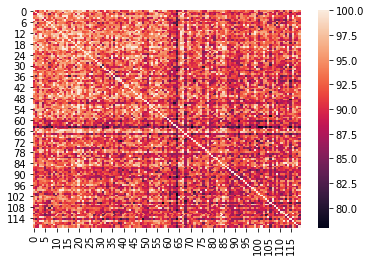

In [64]:
sns.heatmap(K, vmax = 100)

In [3]:
graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')   
init_kernel = gk.GraphKernel(kernel= kernel, normalize=False, n_jobs= 4)
init_kernel.fit(graph_list)


GraphKernel(kernel=[{'L': 2, 'd': 6, 'name': 'pyramid_match',
                     'with_labels': False}],
            n_jobs=4)

In [4]:

MMD_functions = [mg.MMD_b, mg.MMD_u]

# initialize bootstrap class, we only want this to be initalized once so that numba njit
# only gets compiled once (at first call)
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments=[dict(n = bg1.n, m = bg2.n ), dict(n = bg1.n, m = bg2.n )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000)
print(kernel_hypothesis.p_values)


{'MMD_b': 1.0, 'MMD_u': 1.0}


In [29]:
P = np.array([[0.15, 0.05, 0.02], [0.05, 0.25, 0.07], [0.02, 0.07, 0.2]])
sizes = [30, 20, 25]
G = nx.stochastic_block_model(sizes, P)
G.nodes(True)

NodeDataView({0: {'block': 0}, 1: {'block': 0}, 2: {'block': 0}, 3: {'block': 0}, 4: {'block': 0}, 5: {'block': 0}, 6: {'block': 0}, 7: {'block': 0}, 8: {'block': 0}, 9: {'block': 0}, 10: {'block': 0}, 11: {'block': 0}, 12: {'block': 0}, 13: {'block': 0}, 14: {'block': 0}, 15: {'block': 0}, 16: {'block': 0}, 17: {'block': 0}, 18: {'block': 0}, 19: {'block': 0}, 20: {'block': 0}, 21: {'block': 0}, 22: {'block': 0}, 23: {'block': 0}, 24: {'block': 0}, 25: {'block': 0}, 26: {'block': 0}, 27: {'block': 0}, 28: {'block': 0}, 29: {'block': 0}, 30: {'block': 1}, 31: {'block': 1}, 32: {'block': 1}, 33: {'block': 1}, 34: {'block': 1}, 35: {'block': 1}, 36: {'block': 1}, 37: {'block': 1}, 38: {'block': 1}, 39: {'block': 1}, 40: {'block': 1}, 41: {'block': 1}, 42: {'block': 1}, 43: {'block': 1}, 44: {'block': 1}, 45: {'block': 1}, 46: {'block': 1}, 47: {'block': 1}, 48: {'block': 1}, 49: {'block': 1}, 50: {'block': 2}, 51: {'block': 2}, 52: {'block': 2}, 53: {'block': 2}, 54: {'block': 2}, 55: {'

In [18]:
label = nx.get_node_attributes(G, 'block')

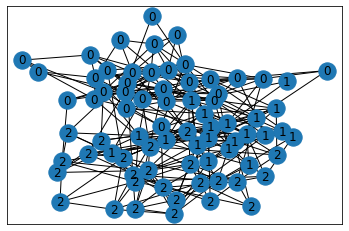

In [21]:
nx.draw_networkx(G, labels = label)